# Customer Segmentation and Content Based Recomendation

By:

- Ferry Marcellus Suhendra
- Hedy Fernando
- Naomi Amelia 
- Raihan Rafif

## Overview

Customer loyalty is crucial for the survival of any kinds of commerce, particularly the e-commerce which undergoes exponential growth these past few years. Thus, the need of an analysis tool to gain knowledge of customer behaviour and to do certain demeanor towards the customers. One of the analysis tool to gain this knowledge is the RFM (Recency, Frequency and Monetary) where we can group the customers into their recency (the latest occurance of purchase), frequency (the number of times a customer make a purchase in the store) and their monetary (the amount of spending each customer undergoes in each purchases). 

Other than that, we can also gain knowledge regarding our products and how they perform with our customers since we need them to stay loyal to our store by purchasing the right products. Thus, the need of a recommendation system is also crucial in the survival of our store. 

## Objective

From the overview above, we can then derive objectives which will be used to shape our overall analysis and problem solving

1. Create customer segmentation modelling 
2. Create product segmentation modelling
3. Create product recommendation system 

## Data Overview

In order to gain thorough analysis of the objective, we will be using data from H&M Group that we derived from Kaggle website (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data). The reasoning behind the opting of this dataset is due to the fact the H&M Group is one of the largest chain in the fashion industry and such, has an immense entries of data. 

### Import Libraries

In this section we will be importing the libraries needed to proceed with our process of obtaining the objectives above.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances,cosine_similarity
import cv2
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt

# RFM (Recency, Frequency & Monetary)

## RFM Customer Segmentation

### Data Loading

The H&M Group offers 4 datasets in which three of them are CSV (comma separated values) format and the other is an image dataset. In this section we will be extracting the CSV datasets and conduct analysis based on them. 

The datasets have been downloaded locally from the link listed before and thus we will be loading all of the data by using Pandas library.

In [40]:
# Loading all .csv data
df_articles = pd.read_csv('articles.csv') # loading the "articles" dataset
df_customers = pd.read_csv('customers.csv') # loading the "customers" dataset
df_transaction = pd.read_csv('transactions_train.csv') # loading the "transactions" dataset
pd.set_option('display.max_columns', None) 

As such, the datasets are all extracted to this notebook. Next, we will be briefly looking at each of the datasets.


In [41]:
df_articles.head() # the .head syntax is to gain information for the first 5 entries in the dataset

article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  \
0                     Solid                  9             Black   
1                     Solid                 10             White   
2                    Stripe                 11         Off White   
3                     Solid                  9             Black   
4                     Solid                 10             White   

   perceived_colour_value_id perceived_colour_value_name  \
0                          4                        Dark   
1                          3                       Light   
2                          1                 Dusty Light   
3                          4                        Dark   
4                          3                       Light   

   perceived_colour_master_id perceived_colour_master_name  department_no  \
0                           5                        Black           1676   
1                           9                        White           1676   
2                           9                        White           1676   
3                           5                        Black           1339   
4                           9                        White           1339   

  department_name index_code        index_name  index_group_no  \
0    Jersey Basic          A        Ladieswear               1   
1    Jersey Basic          A        Ladieswear               1   
2    Jersey Basic          A        Ladieswear               1   
3  Clean Lingerie          B  Lingeries/Tights               1   
4  Clean Lingerie          B  Lingeries/Tights               1   

  index_group_name  section_no            section_name  garment_group_no  \
0       Ladieswear          16  Womens Everyday Basics              1002   
1       Ladieswear          16  Womens Everyday Basics              1002   
2       Ladieswear          16  Womens Everyday Basics              1002   
3       Ladieswear          61         Womens Lingerie              1017   
4       Ladieswear          61         Womens Lingerie              1017   

  garment_group_name                                        detail_desc  
0       Jersey Basic            Jersey top with narrow shoulder straps.  
1       Jersey Basic            Jersey top with narrow shoulder straps.  
2       Jersey Basic            Jersey top with narrow shoulder straps.  
3  Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4  Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...

We can see that the "articles" mainly has the information regarding the products sold and the details of those products. Next we will be looking at the "customers" dataset.

In [42]:
df_customers.head()

customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  NaN     NaN   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  NaN     NaN   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  NaN     NaN   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

The dataset has the information of the customers and whether they are club members or not. The dataset also includes the age of the customers. Next we will be looking at the "transaction" dataset.

In [43]:
df_transaction.head()

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

We can see that the "transaction" dataset includes the transaction date of each customers from the "customers" dataset as well as the article_id from the "articles" dataset. 

Next we will be looking at the data in overall view below

In [44]:
df_articles.info()
# the .info syntax is to briefly check the dataset's number of columns 
# and whether they have missing values or not as well as their type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

We can see that the "articles" dataset has 25 columns with normal (readable) missing values in the the detail_desc column. The columns' types are divided into 2: object and integer. 

Next we will be looking at the "customers" dataset. 

In [45]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


The dataset has 7 columns and an abundance of missing values in all of the columns except for the customer_id and postal_code which have the same amount of entries. There are only two types of the columns which are object and float (decimal). 

Next, we will be looking at the transaction dataset. 

In [46]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


We can see that the `transaction` dataset has the 31 million entries with the type of each column varies from object, integer and float. 

In [47]:
df_transaction['t_dat'] = pd.to_datetime(df_transaction['t_dat'])

The cell above changes the "t_dat" column in `transaction` dataset into date type from string type. We will be checking this in the cell below.

In [48]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB


#### Check Missing Values

In this section we will be checking in more details whether the columns have missing values or not. 

In [49]:
df_articles.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

We can see that there are 416 missing values in the detail_desc.

In [50]:
df_customers.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

As for the `customers` dataset, we can see that the "active" column has the most missing value amongst the other columns. 

In [51]:
df_transaction.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

The `transaction` dataset doesn't have any missing values in the columns

#### Dropping Unused Columns

In [52]:
df_articles.drop('detail_desc', axis=1, inplace=True)

In [53]:
df_customers.drop(['FN','Active','fashion_news_frequency'], axis=1, inplace=True)

In [54]:
age_club_customers_clean = df_customers.dropna(subset=['club_member_status', 'age'])

In [55]:
age_club_customers_clean.isnull().sum()


customer_id           0
club_member_status    0
age                   0
postal_code           0
dtype: int64

#### Check Duplicated Entries

In [14]:
len(df_articles.duplicated()) # this syntax is used to see the number of duplicated entries in the dataset

105542

In [15]:
len(df_customers.duplicated())

1371980

We can see that there are an abundance of duplicated entries in both of the dataset. We will not be dropping these duplicated entries since they hold important information of the dataset.

### RFM data creation

#### Calculating Recency

In this section we will calculate the recency or days since latest purchase of each customer. 

In [56]:
df_recency = df_transaction.groupby(by='customer_id', as_index=False)['t_dat'].max() # grouping by the latest transaction of each customer
df_recency.columns = ['customer_id', 'lastpurchasedate'] # creating latest purchase date column into the dataframe
recent_date = df_recency['lastpurchasedate'].max() # inserting the latest purchase date entries into the dataframe
df_recency['recency'] = df_recency['lastpurchasedate'].apply(
    lambda x: (recent_date - x).days)  # calculating days after last purchases

df_recency.head()

customer_id lastpurchasedate  recency
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...       2020-09-05       17
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...       2020-07-08       76
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...       2020-09-15        7
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...       2019-06-09      471
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...       2020-08-12       41

#### Calculating Frequency

In this section we will be calculating and creating a dataset for the purchase frequency of each customer.

In [57]:
df_frequency = df_transaction.groupby(by='customer_id', as_index=False)['t_dat'].count()
df_frequency.columns = ['customer_id', 'frequency']
df_frequency.head()

customer_id  frequency
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...         21
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...         86
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...         18
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...          2
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...         13

We can see that the dataset contains how many times each customer purchase from the store.

#### Calculating Monetary

In this section we will be conducting the monetary analysis of the customers. 

In [58]:
df_monetary = df_transaction.groupby('customer_id', as_index=False)['price'].count()
df_monetary.columns = ['customer_id', 'monetary']
df_monetary.head()

customer_id  monetary
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...        21
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...        86
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...        18
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...         2
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...        13

#### Merging RFM

After making 3 separate datasets for the recency, frequency and monetary, we will be merging these datasets into one.

In [59]:
df_rf = df_recency.merge(df_frequency, on='customer_id')
df_rfm = df_rf.merge(df_monetary, on='customer_id').drop(columns='lastpurchasedate')

In [60]:
df_rfm

customer_id  recency  \
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...       17   
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...       76   
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...        7   
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...      471   
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...       41   
...                                                    ...      ...   
1362276  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...       16   
1362277  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...       35   
1362278  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...       13   
1362279  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...       92   
1362280  ffffd9ac14e89946416d80e791d064701994755c3ab686...      293   

         frequency  monetary  
0               21        21  
1               86        86  
2               18        18  
3                2         2  
4               13        13  
...            ...       ...  
1362276         51        51  
1362277         84        84  
1362278         45        45  
1362279          7         7  
1362280          1         1  

[1362281 rows x 4 columns]

### Exploratory Data Analysis

The exploratory data analysis is aimed to gain more insight of the RFM dataset that we have created. 

In [61]:
# Creating barplot function

def barplot_date(data, x, y):
    plt.figure(figsize=(18,7))
    ax = sns.barplot(data=data, x=x, y=y)
    for i in ax.containers:
        ax.bar_label(i,)

We will be dividing the transaction years into 3: 2018, 2019, 2020

In [62]:
transaction_2018 = df_transaction[(df_transaction['t_dat'] >= '2018-01-01') & (df_transaction['t_dat'] <= '2018-12-31')]
transaction_2019 = df_transaction[(df_transaction['t_dat'] >= '2019-01-01') & (df_transaction['t_dat'] <= '2019-12-31')]
transaction_2020 = df_transaction[(df_transaction['t_dat'] >= '2020-01-01') & (df_transaction['t_dat'] <= '2020-12-31')]

Next, we will be looking at the transaction gains from each year. 

In [63]:
df_transaction.groupby(df_transaction['t_dat'].dt.year)['price'].sum().to_frame()

price
t_dat               
2018   130873.959305
2019   455604.877966
2020   298167.136780

We can see that 2019 holds the most amount of transaction gain, but for visualizising purposes, we will be creating a pie chart to show the share of sales each year.

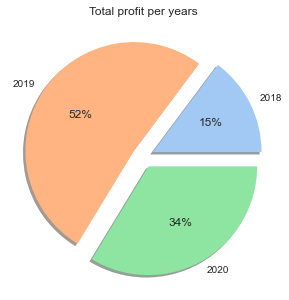

In [64]:
# Create pie chart Total Profit

plt.figure(figsize=(5,5))
plt.title('Total profit per years')

label = df_transaction['t_dat'].dt.year.unique()
colors = sns.color_palette('pastel')
explode = (0.1, 0.1, 0.1)

plt.pie(df_transaction.groupby(df_transaction['t_dat'].dt.year)['price'].sum(),colors=colors,labels=label, explode=explode, 
        autopct='%.0f%%', shadow=True)
plt.show()

2019 holds 52% of the sales share, followed by 2020 with 34% and 2018 with the least amount of 15%. 

#### Price Action

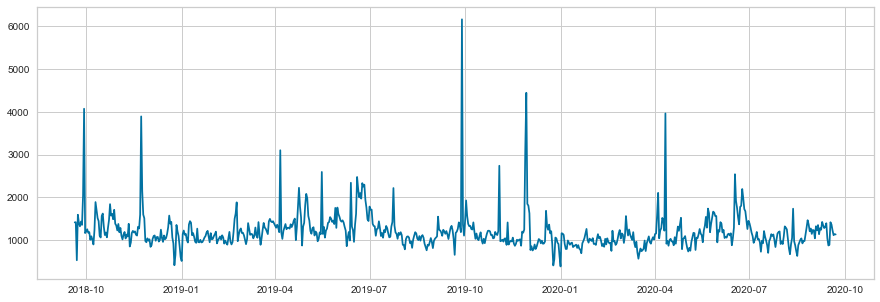

In [65]:
# Price action 2018-2020

plt.figure(figsize=(15,5))
price_line = df_transaction.groupby('t_dat')['price'].sum()
plt.plot(price_line)

We can see from the line chart that there are certain dates with noticeable spikes with the highest spike happened in the 10th month of 2019 with the same instance happened in 2018. We can also see that between November-December we can see this spike happening as well. Yet, we can clearly see that after April of 2020, there are no significant sale spike happening.

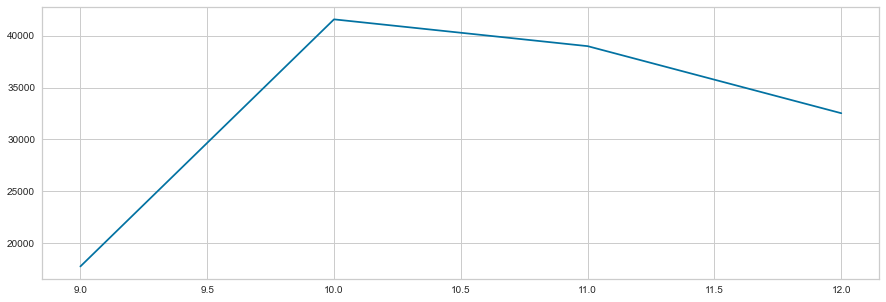

In [66]:
# Price action 2018
plt.figure(figsize=(15,5))
plt.grid=True
price_line = transaction_2018.groupby(transaction_2018['t_dat'].dt.month)['price'].sum()
plt.plot(price_line)

We can see that it is true that October of 2018 holds the most amount of sales, increasing significantly from the previous month. From October onwards we see a gradual decrease of sales. 

Next, we will be looking at the 2019 performance.

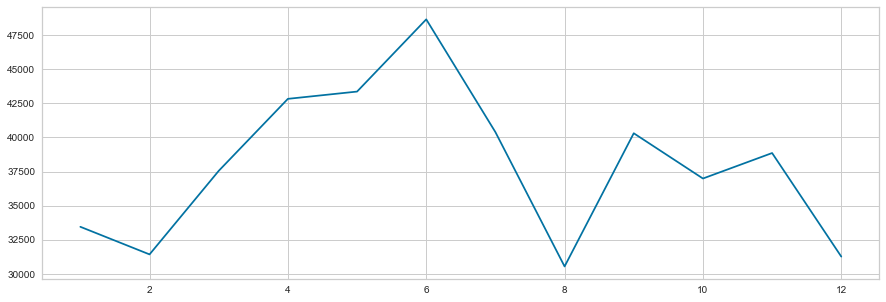

In [67]:
# Price action 2019
plt.figure(figsize=(15,5))
price_line = transaction_2019.groupby(transaction_2019['t_dat'].dt.month)['price'].sum()
plt.plot(price_line)

Furthermore, let us see the 2020 sales performance. 

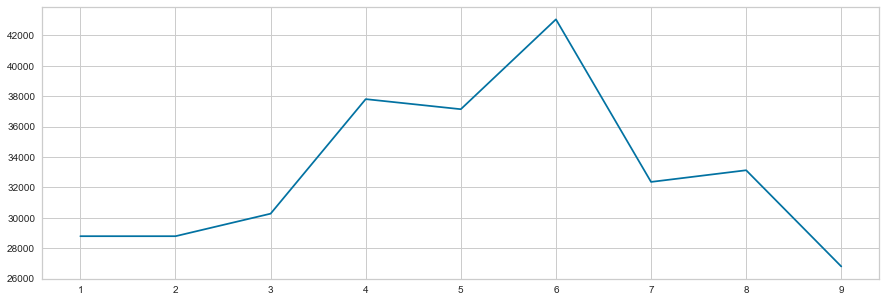

In [68]:
# Price action 2020
plt.figure(figsize=(15,5))
price_line = transaction_2020.groupby(transaction_2020['t_dat'].dt.month)['price'].sum()
plt.plot(price_line)

We can see a spike in June of 2020 then it plumets from there on. We can see that September of 2020 holds the least amount of sales of the year. 

#### Bar Graph and Pie Cahrt

To make the plotting easier to understand, first we must categorize the sum of each products sold into a separate dataframe.

In [83]:
# Creating barplot function

def barplot(data, x, y):
    plt.figure(figsize=(18,7))
    plt.xticks(rotation = 90)
    ax = sns.barplot(data=data, x=x, y=y)
    for i in ax.containers:
        ax.bar_label(i,)

In [84]:
# Join transaction with articles tables
high_prod = df_transaction.join(df_articles.set_index('article_id'), on='article_id')

# create group by for product name
prod_high = high_prod.groupby(by='prod_name', as_index=False)['article_id'].count()
prod_high.columns = ['prod_name', 'count']

# Sort values from high selling
prod_sort = prod_high.sort_values(by='count', ascending=False)
prod_sort.reset_index(drop=True, inplace=True)
prod_sort

prod_name   count
0      Jade HW Skinny Denim TRS  168052
1                Luna skinny RW  143216
2        Timeless Midrise Brief  122143
3                     Tilly (1)  105670
4                      Cat Tee.   81304
...                         ...     ...
45503             Stina overall       1
45504      Relaxed tap basic 79       1
45505          Carrie USB cable       1
45506         Carrie V9 ski jkt       1
45507        Gerda Xmas sweater       1

[45508 rows x 2 columns]

From this dataframe, we can then plot it into a bar graph below.

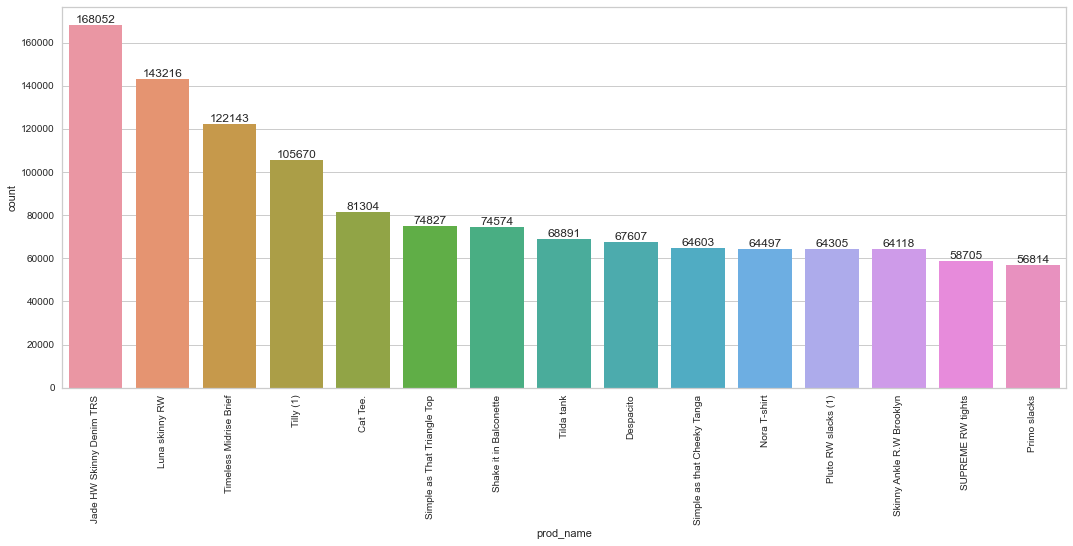

In [85]:
# High Selling Products

barplot(prod_sort[:15],'prod_name','count' )


We can see that the highest selling product is the Jade HW Skinny Denis TRS, followed by Luna Skinny RW, Timeless Midrise Brief, Tilly and Cat Tee. From the Simple as That Triangle Top onwards, we can see that the sales are all in the almost same level. 

In [86]:
# create group by for product group name
prod_group_n = high_prod.groupby(by='product_group_name', as_index=False)['article_id'].count()
prod_group_n.columns = ['prod_group_name', 'count']

# Sort values from high selling for group
prod_group_sort = prod_group_n.sort_values(by='count', ascending=False)
prod_group_sort.reset_index(drop=True, inplace=True)
prod_group_sort.head()

prod_group_name     count
0  Garment Upper body  12552755
1  Garment Lower body   7046054
2   Garment Full body   3552470
3            Swimwear   2579222
4           Underwear   2565858

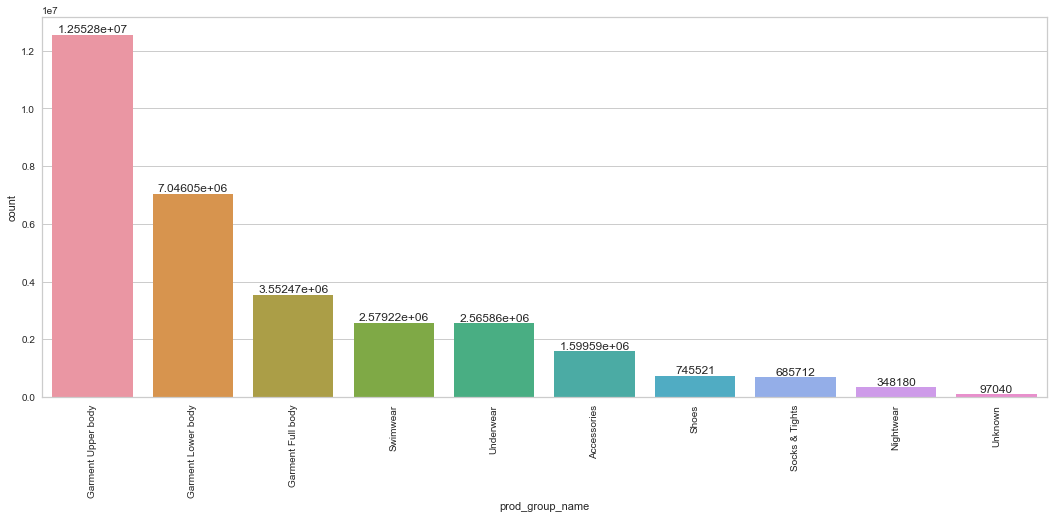

In [87]:
# Product Group Name

barplot(prod_group_sort[:10],'prod_group_name', 'count')


From this bar graph we can see that the Garment Upper Body has the most products with its category, followed by the lower body, full body, swimer and underwear. 

In [88]:
# create group by for product type name
prod_type_n = high_prod.groupby(by='product_type_name', as_index=False)['article_id'].count()
prod_type_n.columns = ['prod_type_name', 'count']

# Sort values from high selling for type name
prod_type_sort = prod_type_n.sort_values(by='count', ascending=False)
prod_type_sort.reset_index(drop=True, inplace=True)
prod_type_sort.head()

prod_type_name    count
0       Trousers  4217017
1          Dress  3238428
2        Sweater  2783274
3        T-shirt  2203750
4            Top  1583408

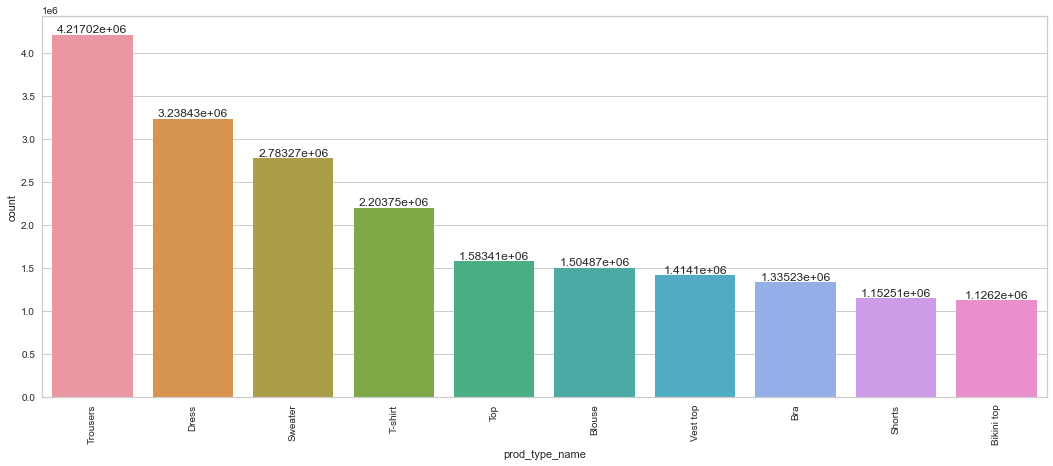

In [89]:
# Product type name

barplot(prod_type_sort[:10],'prod_type_name', 'count')

From this output, we can see that trousers holds the most amount of sales, followed by dress, sweater and t-shirt

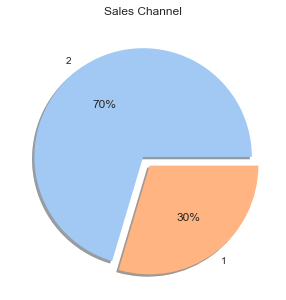

In [90]:
# Create pie chart sales channel

plt.figure(figsize=(5,5))
plt.title('Sales Channel')

label = df_transaction['sales_channel_id'].unique()
colors = sns.color_palette('pastel')
explode = (0, 0.1)

plt.pie(df_transaction['sales_channel_id'].value_counts(),colors=colors,labels=label, explode=explode, 
        autopct='%.0f%%', shadow=True)
plt.show()

The `sales chanel` itself is not clearly explained in the dataset, but we can see that the 70% of the transaction belong to the `2` channel and the rest belong to the `1`.

Next, we will be checking the club member status of the customers. 

In [91]:
age_club_customers_clean['club_member_status'].value_counts()


ACTIVE        1266255
PRE-CREATE      85624
LEFT CLUB         464
Name: club_member_status, dtype: int64

The customers with active member status hold the most amount whereas the ones who left the membership, albeit present, hold the least amount of occurance. We can see the graph below how the membership distribution performs. 

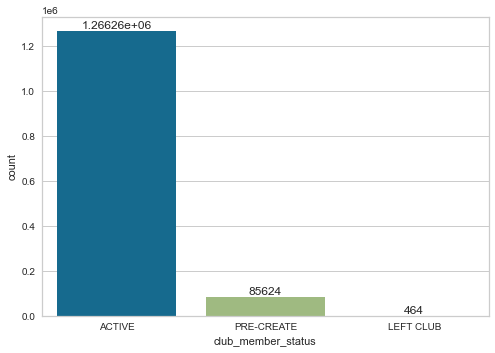

In [92]:
ax = sns.countplot(data=age_club_customers_clean, x='club_member_status')
for i in ax.containers:
    ax.bar_label(i,)

In [93]:
print('Minimal age customers :',age_club_customers_clean['age'].min())
print('Maximal age customers :',age_club_customers_clean['age'].max())

Minimal age customers : 16.0
Maximal age customers : 99.0


The youngest club member is 16 years old, compared to the oldest which is 99, we can see that the age distribution of the members have high variance. We want to look at the age group that we will be plotting below. 

In [94]:
# Slicing age in range
age_slice = age_club_customers_clean.copy()
age_slice['age'] = pd.cut(age_slice['age'], [16,25,45,65,99])

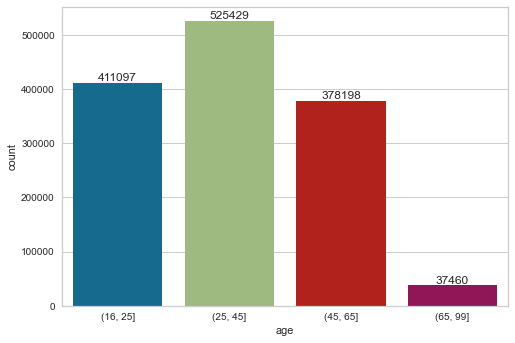

In [95]:
# age in range total

ax = sns.countplot(data=age_slice, x='age')
for i in ax.containers:
    ax.bar_label(i,)

We can see the 25-45 age group has the most amount of members, followed by the 16-25 and 45-65. The 65-99 age group holds the least amount of members. 

In [96]:
# Join transaction with age range
transaction_age = df_transaction.merge(age_slice, on='customer_id')

In [97]:
# create group by for age count repeat order
t_age_repeat = transaction_age.groupby(by='age', as_index=False)['article_id'].count()
t_age_repeat.columns = ['age', 'repeat_order']
t_age_repeat

age  repeat_order
0  (16, 25]       8091649
1  (25, 45]      14548787
2  (45, 65]       8476685
3  (65, 99]        480936

Correlating with the amount of members in each age group, we can see that the 25-45 age group has the most repeated orders between all of the other age group. Although the 45-65 age group has slightly fewer members than that of the 16-25 age group, the repeated order of the 45-65 age group is slightly higher. We can see the plotting below. 

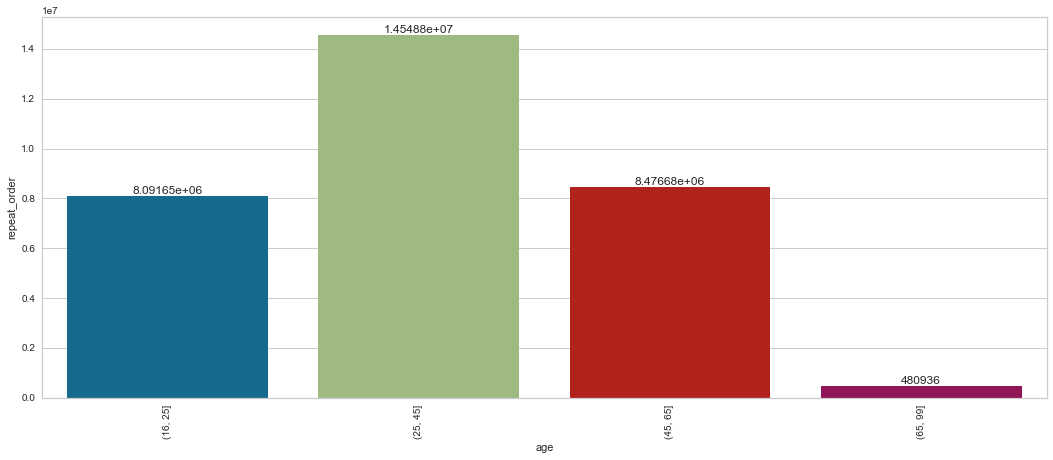

In [98]:
# Count repeat order by age

barplot(t_age_repeat,'age','repeat_order')

In [99]:
# create group by for age count price
t_age_price = transaction_age.groupby(by='age', as_index=False)['price'].sum()
t_age_price.columns = ['age', 'sum_price']
t_age_price

age      sum_price
0  (16, 25]  211995.977119
1  (25, 45]  405946.364559
2  (45, 65]  246652.350898
3  (65, 99]   14792.359136

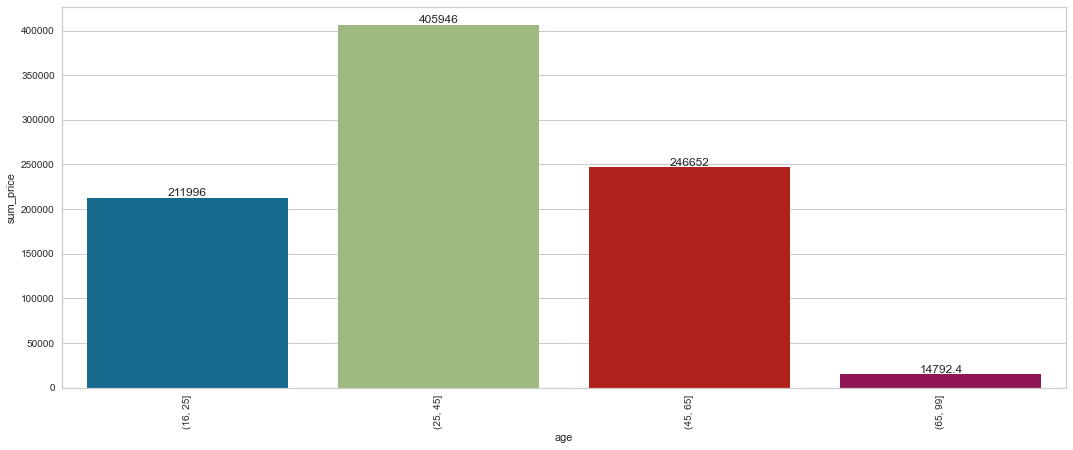

In [100]:
# Sum price by age
barplot(t_age_price, 'age', 'sum_price')


We also want to acknowledge the customers who have spent the most amount of money in our store, thus we will be counting this by the code below:

In [101]:
# create group by for customer total money
c_price = df_transaction.groupby(by='customer_id', as_index=False)['price'].sum()
c_price.columns = ['customer_id', 'sum_price']

# Sort values from high sum_purchase
c_price_sort = c_price.sort_values(by='sum_price', ascending=False)
c_price_sort.reset_index(drop=True, inplace=True)
c_price_sort.head()

customer_id  sum_price
0  be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...  57.676407
1  a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...  50.921186
2  03d0011487606c37c1b1ed147fc72f285a50c05f00b971...  49.967169
3  191071b0e1f2e94a557f1a0b4cea3de55faf1581b1f464...  47.682017
4  b4db5e5259234574edfff958e170fe3a5e13b6f146752c...  47.662000

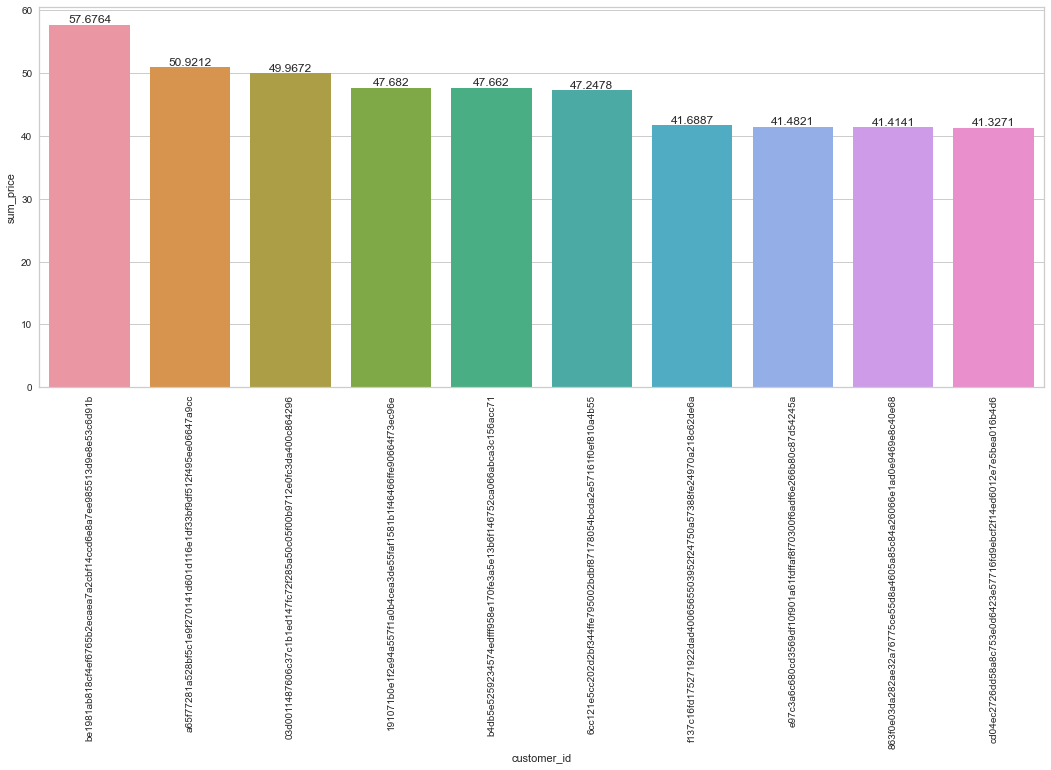

In [102]:
# Customers who have high total price

barplot(c_price_sort[:10],'customer_id','sum_price')

In [103]:
# create group by for customer total money
c_repeat = df_transaction.groupby(by='customer_id', as_index=False)['article_id'].count()
c_repeat.columns = ['customer_id', 'repeat_order']

# Sort values from high sum_purchase
c_repeat_sort = c_repeat.sort_values(by='repeat_order', ascending=False)
c_repeat_sort.reset_index(drop=True, inplace=True)
c_repeat_sort.head()

customer_id  repeat_order
0  be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...          1895
1  b4db5e5259234574edfff958e170fe3a5e13b6f146752c...          1441
2  49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05...          1364
3  a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...          1361
4  cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed...          1237

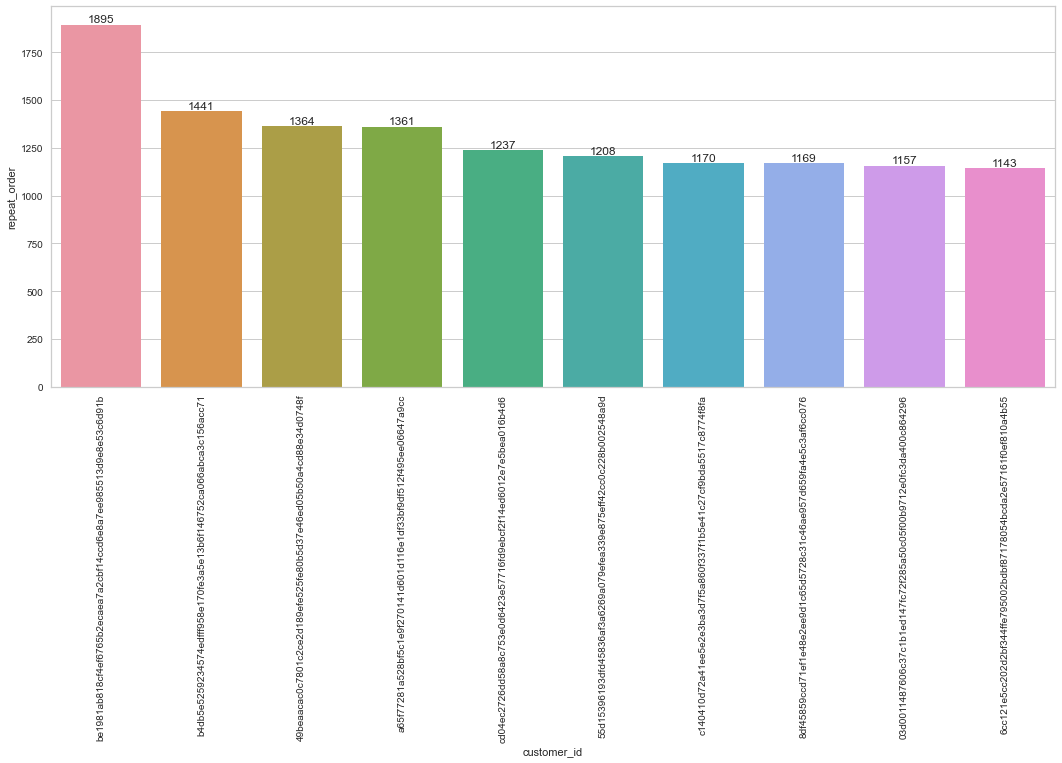

In [104]:
# Customer who has high repeat order
barplot(c_repeat_sort[:10],'customer_id','repeat_order')

### Data Preprocessing

In this section, we will be preprocessing the RFM dataset to gain a more proper model.

#### Checking the Skewness of the Data

The skewness of the data is aimed to gain knowledge whether our data is normally distributed or not, since it will create a bias if the opposite happens. Thus we will be creating a function below to plot as well as give us information regarding the skewness of each of the RFM column. 

In [ ]:
# defining plot function
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
    elif df[col].skew() > 0.5:
        print("Columns '{}' right skewed".format(col))
    elif df[col].skew() < -0.5:
        print("Columns '{}' left skewed".format(col))

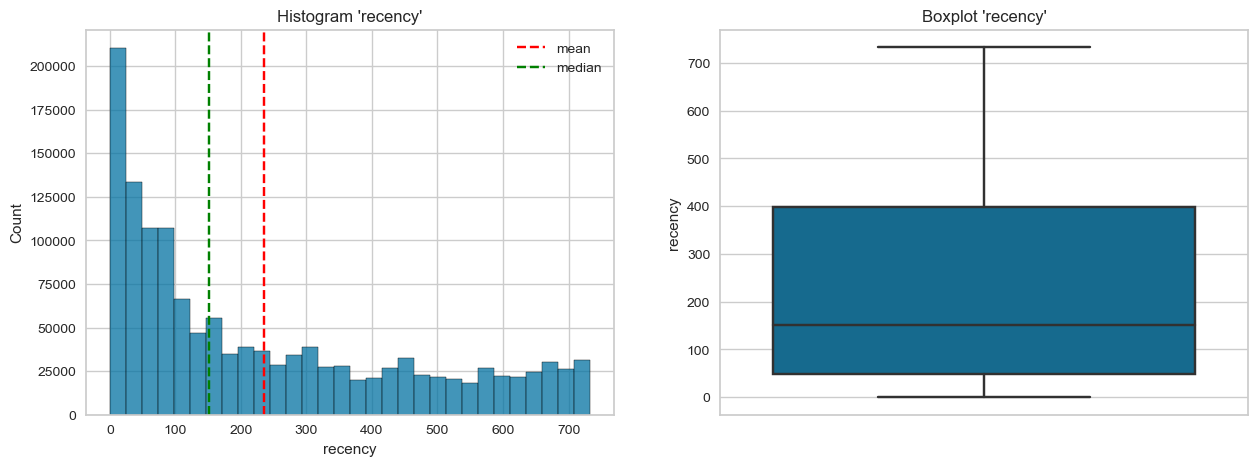

recency Kurtosis: -0.6757738004166298
recency Skewness: 0.8015839691970799
Columns 'recency' right skewed


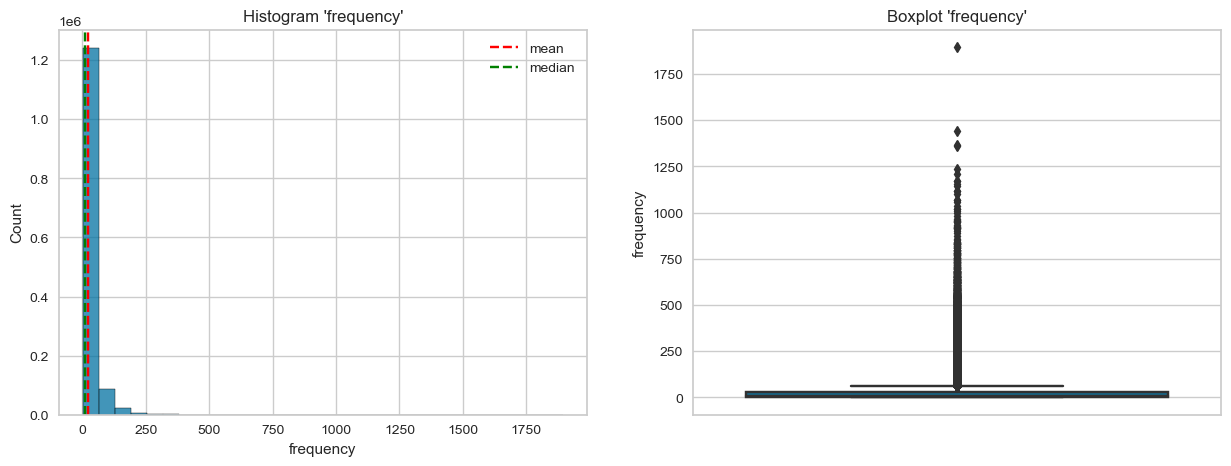

frequency Kurtosis: 56.24939720976781
frequency Skewness: 5.243189357560082
Columns 'frequency' right skewed


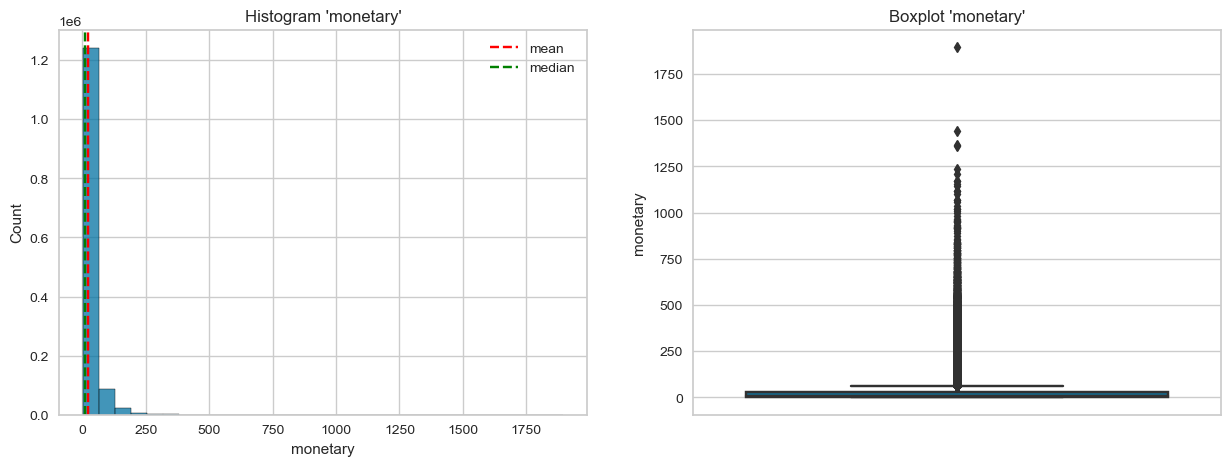

monetary Kurtosis: 56.24939720976781
monetary Skewness: 5.243189357560082
Columns 'monetary' right skewed


In [ ]:
# checking for data skewness and outlier
for col in ['recency','frequency','monetary']:
    plot_dist(df_rfm,col)

We can see that recency is only slightly skewed whereas the frequency and monetary columns are extremely skewed. This is due to the fact that there are an abundance of customers who purchase with extremely high frequency and spendinng. 

With this, we cannot cut the outliers since they hold too much information and thus we will be scaling the data which is the next data prepocessing step. 

In [ ]:
# Defining features
df_rfm_x= df_rfm[['recency','frequency','monetary']]
# scaling the data
scaler=RobustScaler()
x=scaler.fit_transform(df_rfm_x)
x=pd.DataFrame(x, columns=df_rfm_x.columns)
x

recency  frequency  monetary
0       -0.382857   0.500000  0.500000
1       -0.214286   3.208333  3.208333
2       -0.411429   0.375000  0.375000
3        0.914286  -0.291667 -0.291667
4       -0.314286   0.166667  0.166667
...           ...        ...       ...
1362276 -0.385714   1.750000  1.750000
1362277 -0.331429   3.125000  3.125000
1362278 -0.394286   1.500000  1.500000
1362279 -0.168571  -0.083333 -0.083333
1362280  0.405714  -0.333333 -0.333333

[1362281 rows x 3 columns]

### Model Definition & Training

The model that we will be using is mainly aimed for clustering purposes, thus we will be using the K-Means model. This model is specifically used for clustering where it can group the data into desired number of groups. 

The algorithm that we will be using is the `lloyd` or `full`

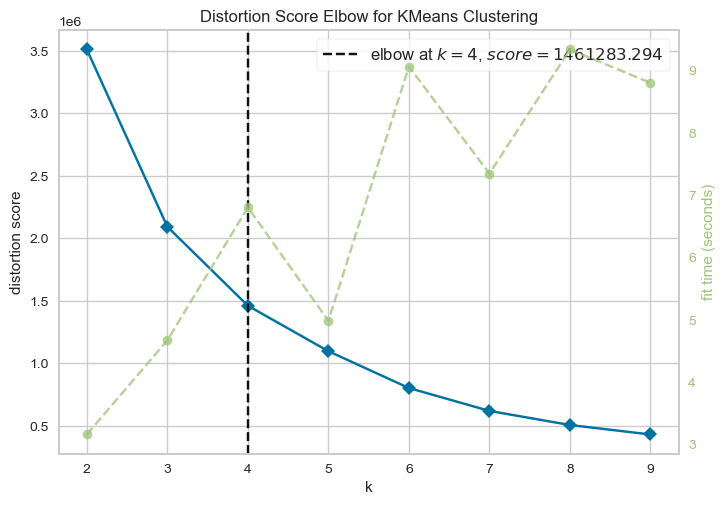

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# defining models
km_model = KMeans(algorithm='full',random_state=32)
# Showing elbow point
Elbow_M = KElbowVisualizer(km_model, k=9)
Elbow_M.fit(x)
Elbow_M.show()

It is found that the elbow value of the model is at 4. This will be set as the number of clusters for the model.

In [ ]:
# redefining model
km_model = KMeans(algorithm='full',n_clusters=4,random_state=32)

In [ ]:
# Training the model
km_model.fit_predict(x)

array([0, 1, 0, ..., 3, 0, 0])

Since the data has multi dimensions, we will be using PCA (Principal Component Analysis) to reduct the dimensionality. In turn, it will be increasing interpretability but at the same time minimizing information loss.

In [ ]:
# reducing data to 2 dimensions for visualization
pca=PCA(n_components=2)
xp=pca.fit_transform(x)
xp

array([[-0.07193546, -0.63421617],
       [ 3.71986545, -0.0678231 ],
       [-0.24477719, -0.68103563],
       ...,
       [ 1.33578353, -0.49835645],
       [-0.91471897, -0.50697676],
       [-1.32613709,  0.02738194]])

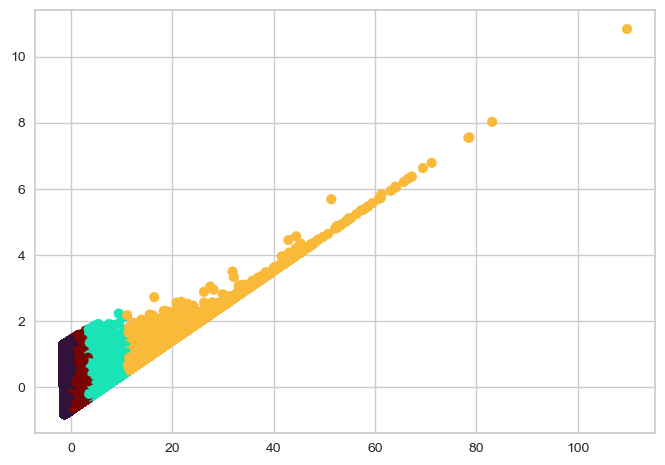

In [ ]:
# plotting model labels
plt.scatter(xp[:,0],xp[:,1],c=km_model.labels_,cmap='turbo')
plt.show()

By the K-means model and the PCA that we have defined earlier through the scatter plot, we can see that the customers are divided into 4 clusters, the purple, red, green and yellow. We can also see that the yellow cluster is more scattered compared to the others.

The next step that we will be doing is predict categories of the customers by the K-Means model. Each customer will be categorized into a particular class that we will be defining later on. Thus, we will be creating a dataframe that holds this categorization.

In [ ]:
# defining prediction data
y_pred=km_model.labels_
y_pred_df=pd.DataFrame(y_pred)
y_pred_df=y_pred_df.reset_index(drop=True)

dfa=pd.concat([df_rfm,y_pred_df],axis=1)
dfa.rename({0:'category'},axis=1,inplace=True)
dfa

customer_id  recency  \
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...       17   
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...       76   
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...        7   
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...      471   
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...       41   
...                                                    ...      ...   
1362276  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...       16   
1362277  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...       35   
1362278  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...       13   
1362279  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...       92   
1362280  ffffd9ac14e89946416d80e791d064701994755c3ab686...      293   

         frequency  monetary  category  
0               21        21         0  
1               86        86         1  
2               18        18         0  
3                2         2         0  
4               13        13         0  
...            ...       ...       ...  
1362276         51        51         3  
1362277         84        84         1  
1362278         45        45         3  
1362279          7         7         0  
1362280          1         1         0  

[1362281 rows x 5 columns]

### Post-model Data Analysis

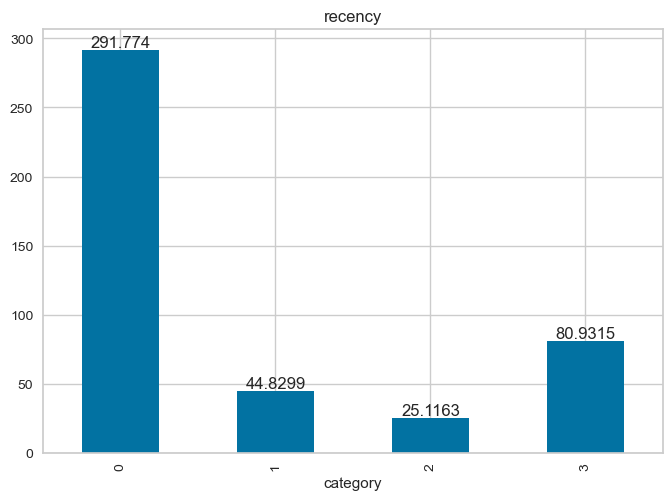

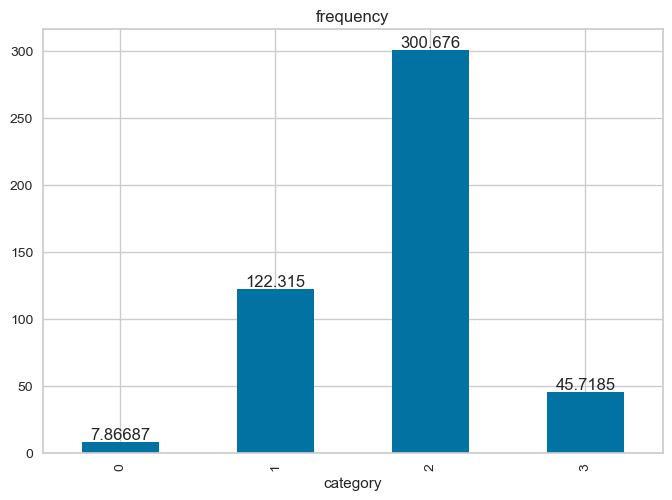

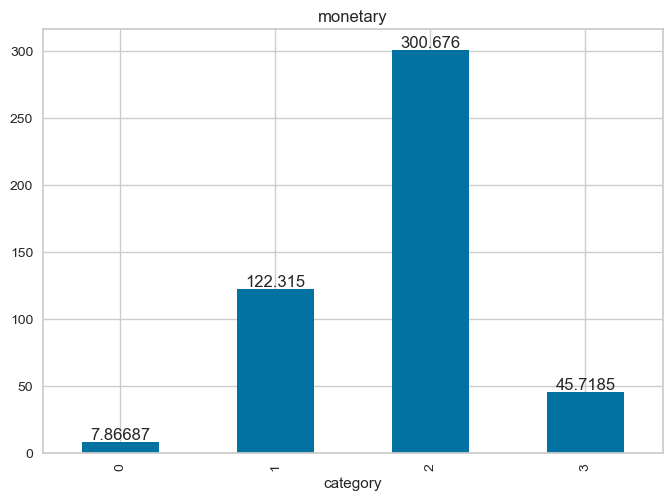

In [ ]:
for col in ['recency','frequency','monetary']:
    
    ax = dfa.groupby('category')[col].mean().plot(kind='bar')
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title(col)
    plt.show()

From the bar graphs, we can gain insights such as:

Regarding the `0` cluster :
    1. The "0" cluster has the lowest recency despite the graph shows the highest in the group. This is due to the fact that the more recent a customer make a purchase, the smaller the recency score is.
    2. It has the lowest frequency of purchase amongst group.
    3. It has the lowest spending compared to the others

Regarding the `1` cluster: 
    1. The `1` cluster has qute high recency which indicates that this cluster has customers that recently purchased something from the store.
    2. It has the second highest frequency of purchase. 
    3. It has the second highest spending 

Regarding the `2` cluster:
    1. The `2` cluster has the highest recency with customers purchasing something more recent than those of the `1` cluster
    2. It has the highest frequency of purchase, towering the others by contrast.
    3. It has the highest spending compared to the others.

Regarding the `3` cluster:
    1. The `3` cluster has the middle ground for every recency, frequency and monetary.


By this insight we then categorize each customer by putting labels in a different column within the same dataframe. Where the `2` cluster now holds the title of `Loyal Customer`, the `1` cluster with the title of `Middle Customer` and the `3` cluster is categorized as `Low Customer`. We label the `0` cluster as the `Near Lost Customer` due to the fact that they have the lowest RFM compared to the other clusters. 

In [ ]:
# Change the category name for customers segmentation
dfa['category'] = np.where(dfa['category'] ==
                                      2, "Loyal Customers",
                                      (np.where(
                                        dfa['category'] == 1,
                                        "Middle Customers",
                                        (np.where(dfa['category'] == 3,
                            'Low Customers', 'Near Lost')))))
dfa

customer_id  recency  \
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...       17   
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...       76   
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...        7   
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...      471   
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...       41   
...                                                    ...      ...   
1362276  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...       16   
1362277  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...       35   
1362278  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...       13   
1362279  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...       92   
1362280  ffffd9ac14e89946416d80e791d064701994755c3ab686...      293   

         frequency  monetary          category  
0               21        21         Near Lost  
1               86        86  Middle Customers  
2               18        18         Near Lost  
3                2         2         Near Lost  
4               13        13         Near Lost  
...            ...       ...               ...  
1362276         51        51     Low Customers  
1362277         84        84  Middle Customers  
1362278         45        45     Low Customers  
1362279          7         7         Near Lost  
1362280          1         1         Near Lost  

[1362281 rows x 5 columns]

With the RFM finished we can then move on to our next objective, the product category segmentation. 

## Product Category Segmentation

### Exploratory Data Analysis and Data Preprocessing

In [ ]:
df_transaction

t_dat                                        customer_id  \
0        2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
1        2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
2        2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
3        2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
4        2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
...             ...                                                ...   
31788319 2020-09-22  fff2282977442e327b45d8c89afde25617d00124d0f999...   
31788320 2020-09-22  fff2282977442e327b45d8c89afde25617d00124d0f999...   
31788321 2020-09-22  fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...   
31788322 2020-09-22  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...   
31788323 2020-09-22  fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...   

          article_id     price  sales_channel_id  
0          663713001  0.050831                 2  
1          541518023  0.030492                 2  
2          505221004  0.015237                 2  
3          685687003  0.016932                 2  
4          685687004  0.016932                 2  
...              ...       ...               ...  
31788319   929511001  0.059305                 2  
31788320   891322004  0.042356                 2  
31788321   918325001  0.043203                 1  
31788322   833459002  0.006763                 1  
31788323   898573003  0.033881                 2  

[31788324 rows x 5 columns]

In [ ]:
df_articles

article_id  product_code               prod_name  product_type_no  \
0        108775015        108775               Strap top              253   
1        108775044        108775               Strap top              253   
2        108775051        108775           Strap top (1)              253   
3        110065001        110065       OP T-shirt (Idro)              306   
4        110065002        110065       OP T-shirt (Idro)              306   
...            ...           ...                     ...              ...   
105537   953450001        953450  5pk regular Placement1              302   
105538   953763001        953763       SPORT Malaga tank              253   
105539   956217002        956217         Cartwheel dress              265   
105540   957375001        957375        CLAIRE HAIR CLAW               72   
105541   959461001        959461            Lounge dress              265   

       product_type_name  product_group_name  graphical_appearance_no  \
0               Vest top  Garment Upper body                  1010016   
1               Vest top  Garment Upper body                  1010016   
2               Vest top  Garment Upper body                  1010017   
3                    Bra           Underwear                  1010016   
4                    Bra           Underwear                  1010016   
...                  ...                 ...                      ...   
105537             Socks      Socks & Tights                  1010014   
105538          Vest top  Garment Upper body                  1010016   
105539             Dress   Garment Full body                  1010016   
105540         Hair clip         Accessories                  1010016   
105541             Dress   Garment Full body                  1010016   

       graphical_appearance_name  colour_group_code colour_group_name  \
0                          Solid                  9             Black   
1                          Solid                 10             White   
2                         Stripe                 11         Off White   
3                          Solid                  9             Black   
4                          Solid                 10             White   
...                          ...                ...               ...   
105537           Placement print                  9             Black   
105538                     Solid                  9             Black   
105539                     Solid                  9             Black   
105540                     Solid                  9             Black   
105541                     Solid                 11         Off White   

        perceived_colour_value_id perceived_colour_value_name  \
0                               4                        Dark   
1                               3                       Light   
2                               1                 Dusty Light   
3                               4                        Dark   
4                               3                       Light   
...                           ...                         ...   
105537                          4                        Dark   
105538                          4                        Dark   
105539                          4                        Dark   
105540                          4                        Dark   
105541                          1                 Dusty Light   

        perceived_colour_master_id perceived_colour_master_name  \
0                                5                        Black   
1                                9                        White   
2                                9                        White   
3                                5                        Black   
4                                9                        White   
...                            ...                          ...   
105537                           5                        Black   
105538      

The two dataframe has the same column which is the `article_id`, thus we will be merging these two dataframes by this column and create a new dataframe from them.

In [ ]:
df_category = pd.merge(df_transaction,
                       df_articles,
                       how='left',
                       left_on=df_transaction['article_id'], 
                       right_on=df_articles['article_id']
)

In [ ]:
df_category['article_id_y'].value_counts()

706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
             ...  
520736002        1
619777003        1
586904003        1
512385003        1
533261032        1
Name: article_id_y, Length: 104547, dtype: int64

We then want to see how each product which has unique id performs in sales. 

In [ ]:
df_category_gr1=df_category.groupby('article_id_y',as_index=False)['article_id_x'].count()
df_category_gr1.columns = ['product_id', 'sales_count']
df_category_gr1

product_id  sales_count
0        108775015        10841
1        108775044         7250
2        108775051          215
3        110065001         1044
4        110065002          539
...            ...          ...
104542   952267001           41
104543   952938001            9
104544   953450001           17
104545   953763001           35
104546   956217002           21

[104547 rows x 2 columns]

Furthermore, we want to see the price of each product by using the code below.

In [ ]:
df_category_gr2=df_category.groupby('article_id_y',as_index=False)['price'].mean()
df_category_gr2.columns = ['product_id', 'price']
df_category_gr2

product_id     price
0        108775015  0.008142
1        108775044  0.008114
2        108775051  0.004980
3        110065001  0.020219
4        110065002  0.018205
...            ...       ...
104542   952267001  0.014982
104543   952938001  0.048006
104544   953450001  0.016836
104545   953763001  0.021908
104546   956217002  0.059152

[104547 rows x 2 columns]

Then, we merge the two dataframes above into a new dataframe that we will visualize using the plotting function that we have created in the RFM data preprocessing section.

In [ ]:
df_category_grf = df_category_gr1.merge(df_category_gr2, on='product_id')


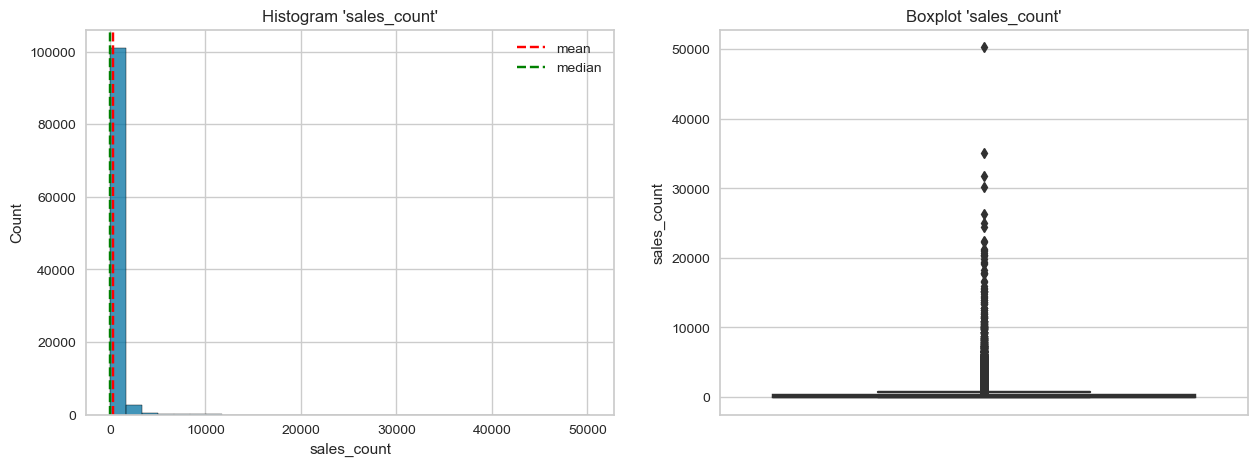

sales_count Kurtosis: 377.2763593243197
sales_count Skewness: 12.830078689007399
Columns 'sales_count' right skewed


price Kurtosis: 44.593896130200704
price Skewness: 4.812431177668909
Columns 'price' right skewed


In [ ]:
for col in ['sales_count','price']:
    plot_dist(df_category_grf,col)

From the plots above, we can see that both sales and price have extreme outliers, meaning there are products sold at extreme amount and price. Since we will not be cutting these outliers due to the fact it has important information regarding the products sold, we will be continuing to the scaling process.

In [ ]:
product_cluster= df_category_grf[['sales_count','price']]

prod=scaler.fit_transform(product_cluster)
prod=pd.DataFrame(prod, columns=product_cluster.columns)
prod

sales_count     price
0         39.617647 -0.761242
1         26.415441 -0.762667
2          0.551471 -0.924406
3          3.599265 -0.137989
4          1.742647 -0.241902
...             ...       ...
104542    -0.088235 -0.408256
104543    -0.205882  1.295917
104544    -0.176471 -0.312547
104545    -0.110294 -0.050835
104546    -0.161765  1.871103

[104547 rows x 2 columns]

The cluster ammount of the this modeling will follow the same amount of clusters on the previous modeling in order to create product clusters that can be paired to the customer clusters.

In [ ]:
cluster_model = KMeans(algorithm='full',n_clusters=4,random_state=32)

In [ ]:
cluster_model.fit_predict(prod)

array([3, 2, 0, ..., 0, 0, 0])

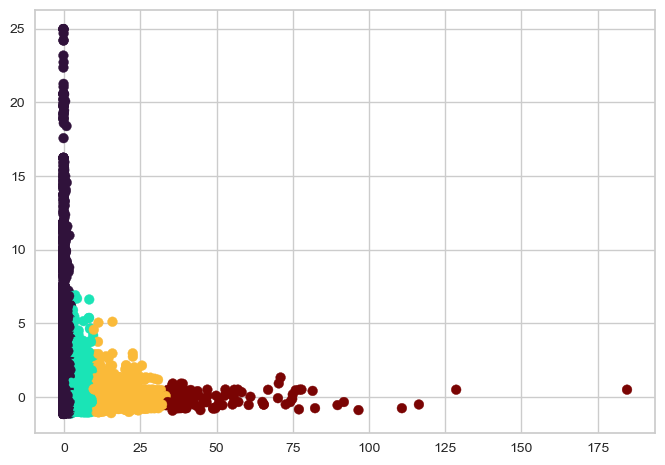

In [ ]:
plt.scatter(x=prod['sales_count'],y=prod['price'],c=cluster_model.labels_,cmap='turbo')
plt.show()

In [ ]:
cat_pred=cluster_model.labels_
cat_pred_df=pd.DataFrame(cat_pred)
cat_pred_df=cat_pred_df.reset_index(drop=True)

prod_cat=pd.concat([df_category_grf,cat_pred_df],axis=1)
prod_cat.rename({0:'class'},axis=1,inplace=True)
prod_cat

product_id  sales_count     price  class
0        108775015        10841  0.008142      3
1        108775044         7250  0.008114      2
2        108775051          215  0.004980      0
3        110065001         1044  0.020219      1
4        110065002          539  0.018205      0
...            ...          ...       ...    ...
104542   952267001           41  0.014982      0
104543   952938001            9  0.048006      0
104544   953450001           17  0.016836      0
104545   953763001           35  0.021908      0
104546   956217002           21  0.059152      0

[104547 rows x 4 columns]

### Post-Modeling Data Analysis

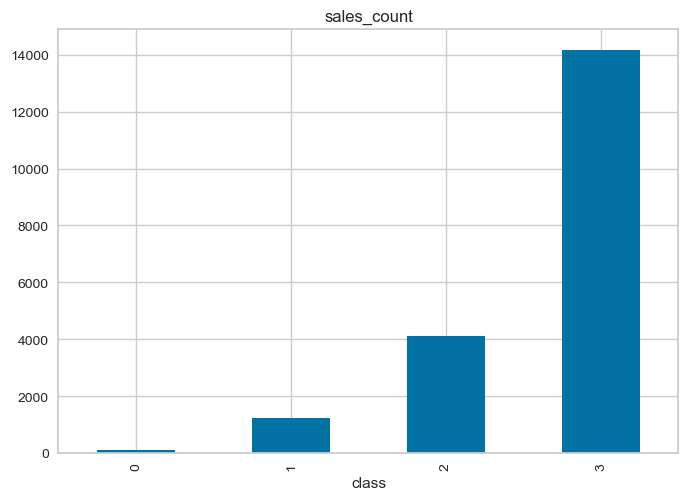

In [ ]:
for col in ['price','sales_count']:
    prod_cat.groupby('class')[col].mean().plot(kind='bar')
    plt.title(col)
    plt.show()

From this bar graphs we can gain information such as:

1. The highest price products belong the the `0` cluster and this can be proved with the low sales count in the second bar graph. 
2. As for the `3` cluster, we can see that the products have lowest price, but at the same time, the cluster has the highest sales count. 
3. There is a contrast difference between the `3` cluster in sales count compared to the other clusters, but this does not apply to the pricing of the products. We can see the the price only differs slightly, yet the outcome of it (sales count) is in outstanding difference.


By this, we then categorize the product by the clustering we have gained from the model. The products that belong to the `1` cluster will be labelled as high end due to the fact that they have higher price and lower sales. The `2` belongs to the middle end, the `3` with low end and the `0` with luxury.

In [ ]:
# Change the category name for product segmentation
prod_cat['class_def'] = np.where(prod_cat['class'] ==
                                      1, "High end",
                                      (np.where(
                                        prod_cat['class'] == 2,
                                        "Middle end",
                                        (np.where(prod_cat['class'] == 3,
                            'Low end', 'Luxury')))))
prod_cat

product_id  sales_count     price  class   class_def
0        108775015        10841  0.008142      3     Low end
1        108775044         7250  0.008114      2  Middle end
2        108775051          215  0.004980      0      Luxury
3        110065001         1044  0.020219      1    High end
4        110065002          539  0.018205      0      Luxury
...            ...          ...       ...    ...         ...
104542   952267001           41  0.014982      0      Luxury
104543   952938001            9  0.048006      0      Luxury
104544   953450001           17  0.016836      0      Luxury
104545   953763001           35  0.021908      0      Luxury
104546   956217002           21  0.059152      0      Luxury

[104547 rows x 5 columns]

In [ ]:
prod_cat['class'].value_counts()

Luxury        92057
High end      10994
Middle end     1387
Low end         109
Name: class, dtype: int64

After finishing the segmentation of the products, we will be creating an image-based recommendation system.

# Image based Recommendation System

In this section we will be conducting the creation of image based recommendation system by creating a function based on cosine similarity. Firstly, we must embed the images that we have in the dataset. The term embedding is to transform our images into one dimensional vector so that we can perform the cosine similarity upon.

In [ ]:
# defining function for embedding image

%matplotlib inline
def return_image_embedding(model,img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
img_path = 'Images_s/0108775044.jpg'
return_image_embedding(model,img_path)

1/1 [==============================] - 4s 4s/step


0         1        2         3         4     5         6     7     8     \
0   0.0  2.163665  0.03161  1.354169  0.042176   0.0  0.333276   0.0   0.0   

   9     10    11    12        13        14        15    16        17    18    \
0   0.0   0.0   0.0   0.0  0.085249  0.024378  0.047051   0.0  0.329597   0.0   

   19        20        21       22        23        24        25        26    \
0   0.0  0.105192  2.016409  0.22646  0.259503  0.768116  0.864378  0.093343   

   27    28       29    30        31        32        33        34       35    \
0   0.0   0.0  0.10464   0.0  0.223977  0.014309  0.226894  2.836752  0.01815   

   36        37    38    39    40        41       42        43        44    \
0   0.0  1.963174   0.0   0.0   0.0  1.148124  0.03943  0.212168  0.393564   

       45    46    47    48        49        50    51        52    53    54    \
0  0.009242   0.0   0.0   0.0  1.752755  0.410818   0.0  0.158746   0.0   0.0   

       55    56        57        58       59        60        61    62    \
0  0.017603   0.0  0.363329  0.251029  0.00052  0.087121  0.273869   0.0   

       63    64        65        66    67        68        69    70    71    \
0  0.066316   0.0  0.029241  0.033937   0.0  0.173056  0.157683   0.0   0.0   

   72       73    74        75        76        77        78        79    \
0   0.0  0.09789   0.0  0.579806  1.453467  0.154464  0.160565  0.036055   

       80    81       82    83       84        85    86        87        88    \
0  0.914657   0.0  0.18978   0.0  2.32174  0.012574   0.0  0.728599  0.004922   

       89        90       91    92        93    94    95        96    97    \
0  0.244354  0.103422  0.04588   0.0  0.486079   0.0   0.0  0.112246   0.0   

   98        99        100      101       102      103   104       105   106   \
0   0.0  2.255442  0.045138  0.41275  0.009642  0.00158   0.0  0.010426   0.0   

       107       108       109      110       111       112       113   \
0  0.001269  0.278955  0.266676  0.06608  0.034728  0.220772  0.072431   

       114       115   116       117   118       119       120   121   \
0  0.026064  0.632534   0.0  1.149977   0.0  0.083886  0.233095   0.0   

       122       123       124       125       126       127       128   \
0  1.014693  0.005956  0.010802  0.001632  0.125915  0.048549  0.113876   

       129       130       131       132   133   134   135       136   137   \
0  0.125671  0.012887  0.632052  0.333961   0.0   0.0   0.0  0.623059   0.0   

   138       139       140   141       142   143       144   145   146   147   \
0   0.0  0.161954  1.395794   0.0  1.965659   0.0  0.302298   0.0   0.0   0.0   

       148   149   150       151       152   153       154      155   \
0  0.142648   0.0   0.0  0.833482  0.008184   0.0  0.934075  0.77973   

       156   157       158   159      160       161   162       163      164   \
0  0.512518   0.0  0.069374   0.0  0.60658  0.025561   0.0  0.497139  2.10162   

   165       166   167       168       169   170       171       172   \
0   0.0  0.059774   0.0  0.113319  1.391539   0.0  0.014395  0.012751   

       173       174   175       176   177       178       179       180   \
0  0.027046  0.026363   0.0  2.145877   0.0  0.633403  0.006461  2.270021   

   181       182       183       184   185       186   187       188   189   \
0   0.0  0.718582  0.243652  1.030476   0.0  0.218794   0.0  0.002048   0.0   

       190       191       192       193   194       195      196   197   \
0  0.011713  0.003814  0.203283  0.208638   0.0  1.431911  0.22162   0.0   

      198       199       200   201   202      203       204       205   \
0  0.97546  0.043723  1.339105   0.0   0.0  0.00262  0.280449  0.049941   

       206   207      208   209       210   211       212   213   214   \
0  0.130561   0.0  0.01964   0.0  0.046733   0.0  0.530647   0.0   0.0   

       215       216       217       218   219       220       221       222   \
0  0.613212  0.4627

In [ ]:
images_path = os.listdir('images_s/')
embedding_dfs = pd.DataFrame()
for curr_img in tqdm(images_path):
        curr_df = return_image_embedding(model,'images_s/'+curr_img)
        curr_df['image'] = curr_img
        embedding_dfs = pd.concat([embedding_dfs,curr_df],ignore_index=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


We will not be using all of the images due to time constraint since the image dataset has 100.000+ images and will take multiple days of transforming into vector format. Thus we will use 1000 randomly chosen images from the dataset. 

In [ ]:
embedding_dfs

0         1         2         3         4         5         6  \
0    0.300054  1.800267  0.000000  0.161263  0.184694  0.030781  0.228568   
1    0.000000  2.163665  0.031610  1.354169  0.042176  0.000000  0.333276   
2    0.645087  0.691452  0.050122  0.361583  0.551168  0.006212  0.137911   
3    0.028639  2.028209  0.086303  0.232832  0.000000  0.022181  0.000000   
4    0.038957  1.295068  0.000000  0.018434  0.000000  0.002442  0.064828   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.000000  0.206069  0.186887  0.000000  0.899192  0.078062  0.071407   
996  0.522088  2.633847  0.000000  1.154726  0.429812  0.204310  0.044746   
997  1.170117  3.621575  0.146752  0.183450  0.310938  0.139485  0.025319   
998  0.111112  3.390320  0.217860  0.024329  0.136030  0.165948  0.079356   
999  0.521383  3.353117  0.317869  0.002198  0.391884  0.052309  0.018115   

            7         8         9        10        11        12        13  \
0    0.067783  0.000000  0.000000  0.186216  0.217007  0.006454  0.062866   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.085249   
2    0.000000  0.000000  0.166020  0.065775  0.555074  0.000000  0.295905   
3    0.047839  0.227043  0.000000  0.651110  0.574661  0.569659  0.035200   
4    0.000000  0.369163  0.000000  0.006300  0.043325  0.187737  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.225004  0.000000  0.000000  1.672770  0.818624  1.605150  0.126832   
996  0.645346  0.043347  0.060122  0.202197  0.828934  0.000896  0.047113   
997  1.604183  0.000000  0.000000  0.009580  0.000000  0.116503  0.358487   
998  0.361516  0.000000  0.491748  0.208945  0.000000  0.299281  0.084449   
999  0.496114  0.000000  0.294112  0.062820  0.000000  0.223190  0.293578   

           14        15        16        17        18        19        20  \
0    2.057923  0.150909  0.000000  0.222913  0.023923  0.026903  0.144391   
1    0.024378  0.047051  0.000000  0.329597  0.000000  0.000000  0.105192   
2    0.277524  0.036576  0.000000  0.128818  0.132228  0.694759  0.118414   
3    0.150512  0.298165  0.000000  0.020848  0.090806  3.329796  0.022457   
4    0.468902  0.376332  0.000000  0.770720  0.000000  2.003762  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.090197  0.000000  0.059813  0.222744  0.000000  0.035593  0.169643   
996  1.594091  0.007018  0.000000  0.056746  0.024469  0.015012  0.000000   
997  0.000000  0.000000  0.000000  0.000000  1.087869  0.227157  1.394097   
998  0.035558  0.000000  0.000000  0.000000  0.409324  0.000000  1.326231   
999  0.126701  0.009936  0.000000  0.000000  0.650344  0.000000  1.584077   

           21        22        23        24        25        26        27  \
0    1.377332  0.073280  0.055055  1.004101  0.041970  0.006182  0.000000   
1    2.016409  0.226460  0.259503  0.768116  0.864378  0.093343  0.000000   
2    1.466860  0.293477  0.347313  0.388757  0.023793  2.495064  0.000000   
3    0.922958  0.041123  0.145381  0.262163  0.000000  0.005460  0.000906   
4    0.509969  0.029368  0.401858  1.750259  0.000000  0.591149  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.447090  0.428571  0.175366  0.001516  0.568852  0.002171  0.307006   
996  0.962433  0.281295  0.030598  0.210630  0.869921  0.081065  1.111207   
997  0.738018  0.386913  0.348365  0.047681  0.000105  0.017651  0.040756   
998  0.649340  0.469730  0.702172  0.009126  0.044193  0.003080  0.012294   
999  0.045113  0.003800  0.266383  0.029160  0.000000  0.022920  0.017315   

           28        29        30        31        32        33        34  \
0    0.000000  0.000000  0.064375  0.415936  0.181996  0.364150  2.550390   
1    0.000000  0.104640  0.000000  0.223977  0.014309  0.226894  2.836752   
2    0.157741  0.371091  0.017786  0.116676  0.153698  0.424168  2.021241   
3   

The product_id in the catalogue product that we have created in the product segmentation will be edited to reflect the image file name on the embedded dataframe by adding 0 in fron of the product_id and .jpg behind it. 

In [ ]:
prod_cat_s= prod_cat
prod_cat_s['product_id']=prod_cat_s['product_id'].astype('str')
prod_cat_s['image']= str('0')+prod_cat_s['product_id']+ str('.jpg')
prod_cat_s

product_id  sales_count     price  class   class_def           image
0       108775015        10841  0.008142      3     Low end  0108775015.jpg
1       108775044         7250  0.008114      2  Middle end  0108775044.jpg
2       108775051          215  0.004980      0      Luxury  0108775051.jpg
3       110065001         1044  0.020219      1    High end  0110065001.jpg
4       110065002          539  0.018205      0      Luxury  0110065002.jpg
...           ...          ...       ...    ...         ...             ...
104542  952267001           41  0.014982      0      Luxury  0952267001.jpg
104543  952938001            9  0.048006      0      Luxury  0952938001.jpg
104544  953450001           17  0.016836      0      Luxury  0953450001.jpg
104545  953763001           35  0.021908      0      Luxury  0953763001.jpg
104546  956217002           21  0.059152      0      Luxury  0956217002.jpg

[104547 rows x 6 columns]

Next, we will be joining the product segmentation result and embedded dataframe on the image name.

In [ ]:
# joining product clustering result with image vector
prod_vec= pd.merge(embedding_dfs,
                       prod_cat_s,
                       how='left',
                       left_on=embedding_dfs['image'],
                       right_on=prod_cat_s['image']
)
prod_vec

key_0         0         1         2         3         4  \
0    0108775015.jpg  0.300054  1.800267  0.000000  0.161263  0.184694   
1    0108775044.jpg  0.000000  2.163665  0.031610  1.354169  0.042176   
2    0108775051.jpg  0.645087  0.691452  0.050122  0.361583  0.551168   
3    0110065001.jpg  0.028639  2.028209  0.086303  0.232832  0.000000   
4    0110065002.jpg  0.038957  1.295068  0.000000  0.018434  0.000000   
..              ...       ...       ...       ...       ...       ...   
995  0930919002.jpg  0.000000  0.206069  0.186887  0.000000  0.899192   
996  0932958002.jpg  0.522088  2.633847  0.000000  1.154726  0.429812   
997  0933032001.jpg  1.170117  3.621575  0.146752  0.183450  0.310938   
998  0933032002.jpg  0.111112  3.390320  0.217860  0.024329  0.136030   
999  0933032003.jpg  0.521383  3.353117  0.317869  0.002198  0.391884   

            5         6         7         8         9        10        11  \
0    0.030781  0.228568  0.067783  0.000000  0.000000  0.186216  0.217007   
1    0.000000  0.333276  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.006212  0.137911  0.000000  0.000000  0.166020  0.065775  0.555074   
3    0.022181  0.000000  0.047839  0.227043  0.000000  0.651110  0.574661   
4    0.002442  0.064828  0.000000  0.369163  0.000000  0.006300  0.043325   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.078062  0.071407  1.225004  0.000000  0.000000  1.672770  0.818624   
996  0.204310  0.044746  0.645346  0.043347  0.060122  0.202197  0.828934   
997  0.139485  0.025319  1.604183  0.000000  0.000000  0.009580  0.000000   
998  0.165948  0.079356  0.361516  0.000000  0.491748  0.208945  0.000000   
999  0.052309  0.018115  0.496114  0.000000  0.294112  0.062820  0.000000   

           12        13        14        15        16        17        18  \
0    0.006454  0.062866  2.057923  0.150909  0.000000  0.222913  0.023923   
1    0.000000  0.085249  0.024378  0.047051  0.000000  0.329597  0.000000   
2    0.000000  0.295905  0.277524  0.036576  0.000000  0.128818  0.132228   
3    0.569659  0.035200  0.150512  0.298165  0.000000  0.020848  0.090806   
4    0.187737  0.000000  0.468902  0.376332  0.000000  0.770720  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.605150  0.126832  0.090197  0.000000  0.059813  0.222744  0.000000   
996  0.000896  0.047113  1.594091  0.007018  0.000000  0.056746  0.024469   
997  0.116503  0.358487  0.000000  0.000000  0.000000  0.000000  1.087869   
998  0.299281  0.084449  0.035558  0.000000  0.000000  0.000000  0.409324   
999  0.223190  0.293578  0.126701  0.009936  0.000000  0.000000  0.650344   

           19        20        21        22        23        24        25  \
0    0.026903  0.144391  1.377332  0.073280  0.055055  1.004101  0.041970   
1    0.000000  0.105192  2.016409  0.226460  0.259503  0.768116  0.864378   
2    0.694759  0.118414  1.466860  0.293477  0.347313  0.388757  0.023793   
3    3.329796  0.022457  0.922958  0.041123  0.145381  0.262163  0.000000   
4    2.003762  0.000000  0.509969  0.029368  0.401858  1.750259  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.035593  0.169643  0.447090  0.428571  0.175366  0.001516  0.568852   
996  0.015012  0.000000  0.962433  0.281295  0.030598  0.210630  0.869921   
997  0.227157  1.394097  0.738018  0.386913  0.348365  0.047681  0.000105   
998  0.000000  1.326231  0.649340  0.469730  0.702172  0.009126  0.044193   
999  0.000000  1.584077  0.045113  0.003800  0.266383  0.029160  0.000000   

           26        27        28        29        30        31        32  \
0    0.006182  0.000000  0.000000  0.000000  0.064375  0.415936  0.181996   
1    0.093343  0.000000  0.000000  0.104640  0.000000  0.223977  0.014309   
2    2.495064  0.000000  0.157741  0.371091  0.017786  0.116676  0.153698   
3    0.005460  0.000906  0.117277  1.155212  0.000000 

In [ ]:
# checking for null values
prod_vec.isnull().sum()

key_0           0
0               0
1               0
2               0
3               0
               ..
sales_count    11
price          11
class          11
class_def      11
image_y        11
Length: 2056, dtype: int64

There are 11 images that has no entry in the articles catalog data. These entries will be dropped.

In [ ]:
#dropping null rows

prod_vec=prod_vec.dropna(axis=0)

In [ ]:
# Saving the joined dataframe to CSV format

prod_vec.to_csv('prod_vec.csv')

In [ ]:
prod_vec

key_0         0         1         2         3         4  \
0    0108775015.jpg  0.300054  1.800267  0.000000  0.161263  0.184694   
1    0108775044.jpg  0.000000  2.163665  0.031610  1.354169  0.042176   
2    0108775051.jpg  0.645087  0.691452  0.050122  0.361583  0.551168   
3    0110065001.jpg  0.028639  2.028209  0.086303  0.232832  0.000000   
4    0110065002.jpg  0.038957  1.295068  0.000000  0.018434  0.000000   
..              ...       ...       ...       ...       ...       ...   
993  0930866001.jpg  0.000000  0.146930  0.082916  0.027527  0.737312   
994  0930866002.jpg  0.018103  0.372137  0.082611  0.021280  0.819926   
997  0933032001.jpg  1.170117  3.621575  0.146752  0.183450  0.310938   
998  0933032002.jpg  0.111112  3.390320  0.217860  0.024329  0.136030   
999  0933032003.jpg  0.521383  3.353117  0.317869  0.002198  0.391884   

            5         6         7         8         9        10        11  \
0    0.030781  0.228568  0.067783  0.000000  0.000000  0.186216  0.217007   
1    0.000000  0.333276  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.006212  0.137911  0.000000  0.000000  0.166020  0.065775  0.555074   
3    0.022181  0.000000  0.047839  0.227043  0.000000  0.651110  0.574661   
4    0.002442  0.064828  0.000000  0.369163  0.000000  0.006300  0.043325   
..        ...       ...       ...       ...       ...       ...       ...   
993  0.449541  0.000000  0.010568  0.000000  0.000000  0.332632  0.937352   
994  0.237724  0.194106  0.213349  0.012154  0.000000  0.162417  1.464956   
997  0.139485  0.025319  1.604183  0.000000  0.000000  0.009580  0.000000   
998  0.165948  0.079356  0.361516  0.000000  0.491748  0.208945  0.000000   
999  0.052309  0.018115  0.496114  0.000000  0.294112  0.062820  0.000000   

           12        13        14        15        16        17        18  \
0    0.006454  0.062866  2.057923  0.150909  0.000000  0.222913  0.023923   
1    0.000000  0.085249  0.024378  0.047051  0.000000  0.329597  0.000000   
2    0.000000  0.295905  0.277524  0.036576  0.000000  0.128818  0.132228   
3    0.569659  0.035200  0.150512  0.298165  0.000000  0.020848  0.090806   
4    0.187737  0.000000  0.468902  0.376332  0.000000  0.770720  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
993  0.038477  0.263471  0.869510  0.000000  0.012146  0.000000  0.000000   
994  0.012171  0.290308  2.072524  0.000000  0.023330  0.000000  0.000000   
997  0.116503  0.358487  0.000000  0.000000  0.000000  0.000000  1.087869   
998  0.299281  0.084449  0.035558  0.000000  0.000000  0.000000  0.409324   
999  0.223190  0.293578  0.126701  0.009936  0.000000  0.000000  0.650344   

           19        20        21        22        23        24        25  \
0    0.026903  0.144391  1.377332  0.073280  0.055055  1.004101  0.041970   
1    0.000000  0.105192  2.016409  0.226460  0.259503  0.768116  0.864378   
2    0.694759  0.118414  1.466860  0.293477  0.347313  0.388757  0.023793   
3    3.329796  0.022457  0.922958  0.041123  0.145381  0.262163  0.000000   
4    2.003762  0.000000  0.509969  0.029368  0.401858  1.750259  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
993  2.581022  0.000000  1.527638  1.299274  0.194761  0.000000  1.969227   
994  1.406689  0.000000  1.344064  0.873926  0.032771  0.002087  2.090189   
997  0.227157  1.394097  0.738018  0.386913  0.348365  0.047681  0.000105   
998  0.000000  1.326231  0.649340  0.469730  0.702172  0.009126  0.044193   
999  0.000000  1.584077  0.045113  0.003800  0.266383  0.029160  0.000000   

           26        27        28        29        30        31        32  \
0    0.006182  0.000000  0.000000  0.000000  0.064375  0.415936  0.181996   
1    0.093343  0.000000  0.000000  0.104640  0.000000  0.223977  0.014309   
2    2.495064  0.000000  0.157741  0.371091  0.017786  0.116676  0.153698   
3    0.005460  0.000906  0.117277  1.155212  0.000000 

In [ ]:
#increasing weight of class

prod_vec['class']=prod_vec['class']*10

C:\Users\raiha\AppData\Local\Temp\ipykernel_13932\4082807277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_vec['class']=prod_vec['class']*10


The multiplication of 'class' column is done in order to increase the weight of the class so that it affects the result of cosine similarity analysis better.

In [ ]:
# Dropping unused columns 

prod_vec_s=prod_vec.drop(['key_0','image_y','product_id','sales_count','price','class_def'],axis=1)
prod_vec_s

0         1         2         3         4         5         6  \
0    0.300054  1.800267  0.000000  0.161263  0.184694  0.030781  0.228568   
1    0.000000  2.163665  0.031610  1.354169  0.042176  0.000000  0.333276   
2    0.645087  0.691452  0.050122  0.361583  0.551168  0.006212  0.137911   
3    0.028639  2.028209  0.086303  0.232832  0.000000  0.022181  0.000000   
4    0.038957  1.295068  0.000000  0.018434  0.000000  0.002442  0.064828   
..        ...       ...       ...       ...       ...       ...       ...   
993  0.000000  0.146930  0.082916  0.027527  0.737312  0.449541  0.000000   
994  0.018103  0.372137  0.082611  0.021280  0.819926  0.237724  0.194106   
997  1.170117  3.621575  0.146752  0.183450  0.310938  0.139485  0.025319   
998  0.111112  3.390320  0.217860  0.024329  0.136030  0.165948  0.079356   
999  0.521383  3.353117  0.317869  0.002198  0.391884  0.052309  0.018115   

            7         8         9        10        11        12        13  \
0    0.067783  0.000000  0.000000  0.186216  0.217007  0.006454  0.062866   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.085249   
2    0.000000  0.000000  0.166020  0.065775  0.555074  0.000000  0.295905   
3    0.047839  0.227043  0.000000  0.651110  0.574661  0.569659  0.035200   
4    0.000000  0.369163  0.000000  0.006300  0.043325  0.187737  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
993  0.010568  0.000000  0.000000  0.332632  0.937352  0.038477  0.263471   
994  0.213349  0.012154  0.000000  0.162417  1.464956  0.012171  0.290308   
997  1.604183  0.000000  0.000000  0.009580  0.000000  0.116503  0.358487   
998  0.361516  0.000000  0.491748  0.208945  0.000000  0.299281  0.084449   
999  0.496114  0.000000  0.294112  0.062820  0.000000  0.223190  0.293578   

           14        15        16        17        18        19        20  \
0    2.057923  0.150909  0.000000  0.222913  0.023923  0.026903  0.144391   
1    0.024378  0.047051  0.000000  0.329597  0.000000  0.000000  0.105192   
2    0.277524  0.036576  0.000000  0.128818  0.132228  0.694759  0.118414   
3    0.150512  0.298165  0.000000  0.020848  0.090806  3.329796  0.022457   
4    0.468902  0.376332  0.000000  0.770720  0.000000  2.003762  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
993  0.869510  0.000000  0.012146  0.000000  0.000000  2.581022  0.000000   
994  2.072524  0.000000  0.023330  0.000000  0.000000  1.406689  0.000000   
997  0.000000  0.000000  0.000000  0.000000  1.087869  0.227157  1.394097   
998  0.035558  0.000000  0.000000  0.000000  0.409324  0.000000  1.326231   
999  0.126701  0.009936  0.000000  0.000000  0.650344  0.000000  1.584077   

           21        22        23        24        25        26        27  \
0    1.377332  0.073280  0.055055  1.004101  0.041970  0.006182  0.000000   
1    2.016409  0.226460  0.259503  0.768116  0.864378  0.093343  0.000000   
2    1.466860  0.293477  0.347313  0.388757  0.023793  2.495064  0.000000   
3    0.922958  0.041123  0.145381  0.262163  0.000000  0.005460  0.000906   
4    0.509969  0.029368  0.401858  1.750259  0.000000  0.591149  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
993  1.527638  1.299274  0.194761  0.000000  1.969227  0.136158  0.165902   
994  1.344064  0.873926  0.032771  0.002087  2.090189  1.000279  0.040704   
997  0.738018  0.386913  0.348365  0.047681  0.000105  0.017651  0.040756   
998  0.649340  0.469730  0.702172  0.009126  0.044193  0.003080  0.012294   
999  0.045113  0.003800  0.266383  0.029160  0.000000  0.022920  0.017315   

           28        29        30        31        32        33        34  \
0    0.000000  0.000000  0.064375  0.415936  0.181996  0.364150  2.550390   
1    0.000000  0.104640  0.000000  0.223977  0.014309  0.226894  2.836752   
2    0.157741  0.371091  0.017786  0.116676  0.153698  0.424168  2.021241   
3   

## Model Inference

In this section we will be conducting the cosine similarity analysis by the images in dataset. 

In [ ]:
# Defining a function to show image

def show_img(image_name,title=image_name):
    img_path = 'images_s/'+str(image_name)
    im = cv2.imread(img_path)
    plt.axis('off')
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.show()

In [ ]:
# Defining function to recommend similar product 

def fetch_most_similar_products(image_name,Cust_n,n_similar=3):
    print("-----------------------------------------------------------------------")
    print("Original Product:")
    show_img(image_name,image_name)
    prod_vec_se=prod_vec_s
    prod_vec_se.loc[prod_vec_se['image_x']==image_name, 'class']= Cust_n
    cosine_similarity_df = pd.DataFrame(cosine_similarity(prod_vec_se.drop('image_x',axis=1)))
    curr_index = prod_vec_se[prod_vec_se['image_x']==image_name].index[0]
    closest_image = pd.DataFrame(cosine_similarity_df.iloc[curr_index].nlargest(n_similar+1)[1:])
    print("-----------------------------------------------------------------------")
    print("Recommended Product")
    for index,imgs in closest_image.iterrows():
        similar_image_name = prod_vec_se.iloc[index]['image_x']
        similarity = np.round(imgs.iloc[0],3)
        show_img(similar_image_name,str(similar_image_name)+' nSimilarity : '+str(similarity))

The function above is aimed to show the product that has been chosen by the customer and show product based on the similarity of the product chosen as well as the customer's loyaly class.

Below is the inference of the recommendation system.

-----------------------------------------------------------------------
Original Product:


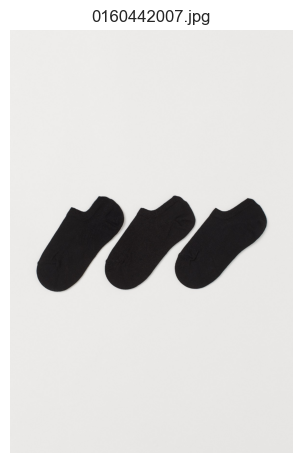

-----------------------------------------------------------------------
Recommended Product


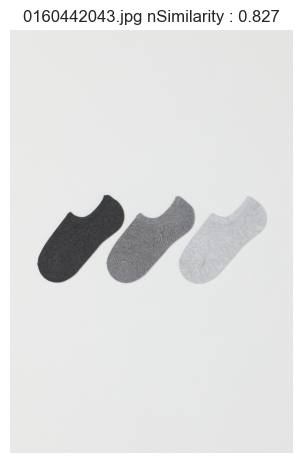

In [ ]:
image_name = '0160442007.jpg' 
Cust_loyalty= 'Middle Customers'
if Cust_loyalty== 'Loyal':
    fetch_most_similar_products(image_name,0)
elif Cust_loyalty== 'Middle Customers':
    fetch_most_similar_products(image_name,10)
elif Cust_loyalty== 'Low Customers':
    fetch_most_similar_products(image_name,20)
elif Cust_loyalty== 'Near Lost':
    fetch_most_similar_products(image_name,30)
else:
    print('Invalid entry')

# Closure

## Conclusion

-  Customer Segmentation Based on RFM 

Based on the clustering model that we have created, the RFM segments the customers into 4 categories which are: Loyal Customer, Middle Customer, Low Customer and Near Lost Customer. loyal customers showed the highest frequency and monetary (sum of purchases) and have the most recent purchase on average. this is all followed in order by middle, low, and near lost customers. By looking at the purchasing habit of customers we can recomend products that fits their category.

- Product Segmentation

Product catalog is segmented using a clustering machine learning model to the same ammount of groups as the customer segmentation based on the product price and sales count. resulting model segments the product catalog to 4 categories: Luxury, High end, Middle end, and Low end. It is found that the majority of products belongs to the luxury product category.

3. Recommendation System

A recommendation system based of cosine similarity can be made to recommend product by image similarity and customer class to product class. The model takes an input of product image and customer class and outputs 3 product images from the catalog with the highest similarity as recommendations.

## Further Improvement

There are a few limitations that we underwent during the course of obtaining the objectives that we set which are: 

- Time constraint 
This is deemed to be the most crucial factor of the whole process where we didn't include all of the image dataset in the transformation to vector format since it will take approximately days to run. 

- Limited variantions of the images
Due to the time limitation, the amount of images also underwent restrictions to only 1000

- Limited product recommendation
The product recommendation is also affected by the two limitations above where the function can only recommend to customer by the available images in the dataset